In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("caracteristiques.csv")
df.head()

,Num_Acc,year,month,day,weekday,hrmn,lum,agg,atm,col,severity,city,adr,gps,lat,long,dep,monthday
0,201600000001,16,2,1,0,1445,1,2,covered weather,3.0,2,5,"46, rue Sonneville",M,0.0,0.0,59,2-1
1,201600000002,16,3,16,2,1800,1,2,normal,6.0,2,5,1a rue du cimetière,M,0.0,0.0,59,3-16
2,201600000003,16,7,13,2,1900,1,1,normal,6.0,2,11,NaN,M,0.0,0.0,59,7-13
3,201600000004,16,8,15,0,1930,2,2,blinding weather,3.0,1,477,52 rue victor hugo,M,0.0,0.0,59,8-15
4,201600000005,16,12,23,4,1100,1,2,normal,3.0,2,11,rue Joliot curie,M,0.0,0.0,59,12-23


# Problématique : Optimiser l'allocation des dépanneuses de la compagnie d'assurance

# Hypothèses:

# H1 : Il y a plus d'accidents pendant vacances scolaires + été + hiver (conditions de routes)

# H2 : Il y a plus d'accidents le vendredi soir pour partir en weekend.

# H3 : Il y a plus d'accidents à partir de 22h (dès qu'il fait noir) + matin

# -----

# Test de H2

C:\Users\Pierre\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='weekday', ylabel='count'>

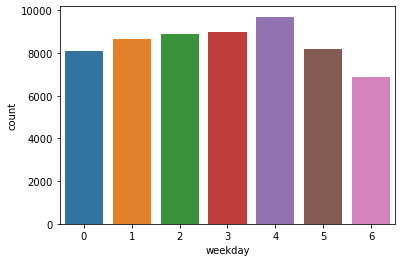

In [2]:
sns.countplot(df['weekday'])

# Ce plot ne permet pas de conclure sur le fait qu'il y aurait plus d'accidents le vendredi en général,
# car il est possible que les différences soient dûs à des évènements exceptionnels comme une chute de neige nationale,
# des inondations, etc etc.

In [3]:
# Pour savoir s'il y a vraiment une différence dans les distributions du nombre d'accidents entre le vendredi
# et les autres jours de la semaine, on utilise un TEST ANOVA.

# Pour utiliser ce test, j'ai besoin d'avoir un DataFrame avec les deux colonnes qui m'intéressent:
# 1 : Le jour de la semaine
# 2 : Le nombre d'accidents pour ce jour.

# La première etape sera donc de compter le nombre d'accidents pour chaque jour de l'année.
# J'utilise une opération groupby pour cela:
num_acc_per_day = df.groupby("monthday").count()['Num_Acc'].reset_index()

# Je fusionne le résultat avec le dataframe de base pour récupérer le weekday.
num_acc_per_day = num_acc_per_day.merge(df, on = 'monthday')\
                                 [['monthday', 'weekday', 'Num_Acc_x', 'month', 'day']]\
                                 .drop_duplicates()\
                                 .rename(columns = {'Num_Acc_x' : 'n_accidents'})

# Je crée une variable binaire m'indiquant si ce jour est un vendredi ou non.
num_acc_per_day['is_friday'] = num_acc_per_day['weekday'] == 4

num_acc_per_day

,monthday,weekday,n_accidents,month,day,is_friday
0,1-1,4,121,1,1,True
121,1-10,6,127,1,10,False
248,1-11,0,153,1,11,False
401,1-12,1,180,1,12,False
581,1-13,2,166,1,13,False
...,...,...,...,...,...,...
58473,9-5,0,200,9,5,False
58673,9-6,1,166,9,6,False
58839,9-7,2,198,9,7,False
59037,9-8,3,183,9,8,False


In [4]:
# Je lance mon test anova. Ce code est copié du module 104 notebook 3.
import statsmodels.api 
result = statsmodels.formula.api.ols('n_accidents ~ is_friday', data = num_acc_per_day).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
is_friday,1.0,26634.239154,26634.239154,25.518021,6.947572e-07
Residual,364.0,379922.208934,1043.742332,NaN,NaN


H_0 : Le nombre d'accidents est independant du jour de la semaine

* Si p-value < 5%:
    * On REJETTE l'hypothèse nulle
    * "On peut conclure que le jour de la semaine a un effet statistique significatif sur le nombre d'accidents quotidien".
    
    
* Si p-value > 5%:
    * SURTOUT NE PAS DIRE : ON ACCEPTE L'HYPOTHESE
    * On ne peut pas conclure


# Test H1

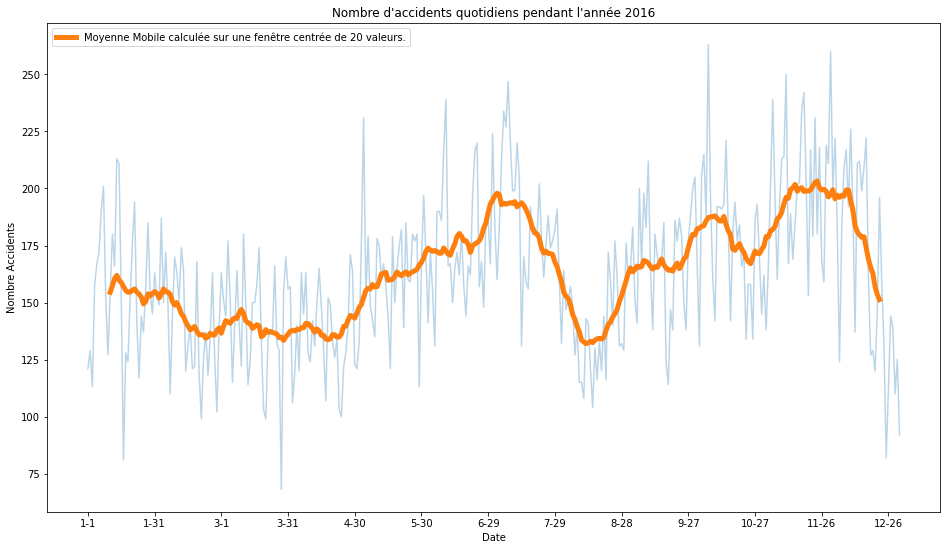

In [5]:
# Ici, je veux faire une visualisation convaincante de la tendance du nombre d'accidents pendant l'année
# afin d'identifier les périodes qui 

# Je trie les lignes par ordre chronologiques pour mon plot
num_acc_per_day = num_acc_per_day.sort_values(by = ['month', 'day'])

# Je calcule la Moyenne MOBILE du nombre d'accidents quotidiens. Cette moyenne est calculée par
# paquets de 20 lignes et permet de LISSER la série temporelle.
MA_accidents = num_acc_per_day['n_accidents'].rolling(20, center = True).mean()


# J'affiche le nombre d'accidents pour chaque jour (ligne bleue)
plt.plot(num_acc_per_day['monthday'], num_acc_per_day['n_accidents'], alpha = 0.3)

# J'affiche la moyenne mobile du nombre d'accidents (ligne orange)
# Ceci met en valeur la tendance globale du nombre d'accidents, contrairement à la courbe bleue qui fait
# mal aux yeux
plt.plot(num_acc_per_day['monthday'], MA_accidents,
         linewidth = 5, label = "Moyenne Mobile calculée sur une fenêtre centrée de 20 valeurs.")

# Je modifie les graduations de l'axe des abscisses pour que ce soit plus clair.
plt.xticks(num_acc_per_day['monthday'][::30])

plt.title("Nombre d'accidents quotidiens pendant l'année 2016")
plt.xlabel("Date")
plt.ylabel("Nombre Accidents")

plt.legend()

# J'agrandis l'image
fig = plt.gcf()
# Le ratio 16:9 est pas mal pour intégrer la figure dans des slides ou 
# simplement projeter la figure sur un écran
fig.set_size_inches(16, 9)

# Je l'enregistre en haute résolution
fig.savefig("image_hd.png", dpi = 300)

## Une fois que l'image est enregistrée, on peut l'insérer dans le markdown pour faire une analyse de la figure.


<img src = "image_hd.png">

On peut voir sur la figure que blablablalalbalala

# Test H3 : Il y a plus d'accidents en soirée et le matin en heure de pointe

In [6]:
# Ici, j'aimerais bien utiliser une technique purement visuelle pour mettre en valeur
# la tendance du nombre d'accidents sur l'échelle d'une journée.

# Pour cela, je vais empiler toutes les courbes quotidiennes du nombre d'accidents par heure
# les unes sur les autres, et grâce à la transparence, la tendance sera explicite.

# La première étape est de compter le nombre d'accidents pour chaque heure de chaque jour de l'année.

# Je récupère l'heure grâce à la division entière de hrmn par 100
df['heure'] = df['hrmn'].apply(lambda x: x // 100)

# Je compte le nombre d'accidents pour chaque heure de chaque jour de mon dataset
n_accidents_heure = df.groupby(['month', 'day', 'heure']).count()['Num_Acc'].reset_index()

# Je re-crée la variable monthday pour avoir une sorte d'identifiant unique du jour la boucle dans la cellule suivante
n_accidents_heure['monthday'] = n_accidents_heure['month'].astype(str) + '-' + n_accidents_heure['day'].astype(str)

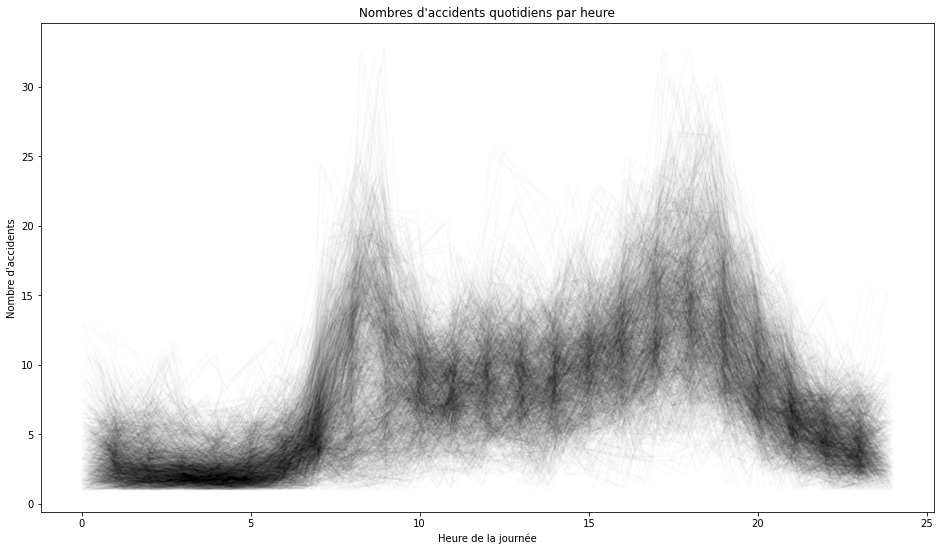

In [7]:
# Pour chaque jour de l'année
for day in n_accidents_heure['monthday'].unique():
    
    # Je récupère les données de ce jour
    data = n_accidents_heure[n_accidents_heure['monthday'] == day]
    
    # Je trace une courbe du nombre d'accidents en fonction de l'heure.
    # Je rajoute un tout petit peu d'aléa dans mes données pour lisser mon affichage
    # et rendre le tassement des courbes plus organique (comparer avec la version
    # dans la cellule suivante).
    # Ce n'est pas gênant car les observations que l'on pourrait faire sur le 
    # graphique seront les mêmes.
    for i in range(5):
        heure = data['heure']
        heure = heure + np.random.rand(len(heure))

        n_acc = data['Num_Acc']
        n_acc = n_acc + np.random.rand(len(n_acc))
    
        plt.plot(heure, n_acc, alpha = 0.015, color = 'black')
    
plt.title("Nombres d'accidents quotidiens par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'accidents")
    
fig = plt.gcf()
fig.set_size_inches(16, 9)